In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0, "./../../")
sys.path.insert(0, "./../../audio/")
sys.path.insert(0, "./../../tacotron2/")
sys.path.insert(0, "./../../waveglow/")

import librosa
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from IPython.display import Audio, display

from audio.vocoders import griffin_lim
from tacotron2.model import Tacotron2
from tacotron2.layers import TTLSTMCell, TTLSTM
from tacotron2.text import text_to_sequence, sequence_to_text
from waveglow.glow import WaveGlow

In [2]:
# Tacotron 2
TACOTRON_CONFIG=json.load(open('./../../tacotron2/config1.json', 'r'))
TACOTRON_CHECKPT='./../../checkpts/tacotron2_statedict.pt'
COMPRESSED_CHECKPT='./../../tacotron2/checkpts1/checkpoint_124500'

# Waveglow
WAVEGLOW_CONFIG=json.load(open('./../../waveglow/config.json', 'r'))
WAVEGLOW_CHECKPT='./../../checkpts/waveglow_256channels_ljs_v3.pt'

# Essential
ON_GPU=False
MAX_WAV_VALUE=32768.0
SIGMA=1.1

### **Build Tacotron 2**

In [3]:
tacotron2 = Tacotron2(TACOTRON_CONFIG)
checkpt_state_dict = torch.load(TACOTRON_CHECKPT,
                                map_location=lambda storage, loc: storage)['state_dict']
tacotron2.load_state_dict(checkpt_state_dict)
_ = tacotron2.cuda().eval() if ON_GPU else tacotron2.cpu().eval()

print('Params number:', tacotron2.nparams())

Params number: 28193153


In [4]:
tacotron2.compress_factorize(config=TACOTRON_CONFIG['compress_config'])

print('Params number of compressed Tacotron 2:', tacotron2.nparams())

Starting Tacotron 2 compression...
compressing linear layers:
compressing decoder.prenet.layers.0.linear_layer.weight... Done
compressing decoder.prenet.layers.1.linear_layer.weight... Done
compressing decoder.attention_layer.query_layer.linear_layer.weight... Done
compressing decoder.attention_layer.memory_layer.linear_layer.weight... Done
compressing decoder.attention_layer.v.linear_layer.weight... Failed
compressing decoder.attention_layer.location_layer.location_dense.linear_layer.weight... Done
compressing decoder.linear_projection.linear_layer.weight... Done
compressing decoder.gate_layer.linear_layer.weight... Failed
compressing rnns:
compressing encoder.lstm... Done
compressing decoder.attention_rnn... Done
compressing decoder.decoder_rnn... Done
Parameters number: 28193153 -> 10944593
TT decreased model size by 61.17996096428093%
Params number of compressed Tacotron 2: 10944593


In [ ]:
tacotron2.load_state_dict(torch.load(COMPRESSED_CHECKPT)['state_dict'])

### **Build Waveglow**

In [5]:
waveglow = torch.load(WAVEGLOW_CHECKPT,
                      map_location=lambda storage, loc: storage)['model']
waveglow = waveglow.remove_weightnorm(waveglow)
_ = waveglow.cuda().eval() if ON_GPU else waveglow.cpu().eval()

### **Inference**
**Prepare texts**

In [6]:
texts = ["Implicit learning of the likelihood makes normalizing flows very strong generative tool.",
         "WaveGlow and L P C Net are accelerated derivatives of WaveNet state-of-the-art model."]
assert len(texts) > 0
texts = [text.strip() for text in texts]
sequences = [np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
             for text in texts]
sequences = [torch.autograd.Variable(torch.from_numpy(sequence)).long()
             for sequence in sequences]

**Synthesis**

In [7]:
from audio import MelTransformer

In [8]:
USE_GLA=True
TEXT_IDX = 0

print(sequence_to_text(map(int, list(sequences[TEXT_IDX].squeeze()))))

total_start = datetime.now()

with torch.no_grad():
    tc_start = datetime.now()
    mel_outputs, mel, gate_outputs, alignments = tacotron2.inference(sequences[TEXT_IDX])
    tc_end = datetime.now()
    
    if not USE_GLA:
        wg_start = datetime.now()
        wave = MAX_WAV_VALUE*waveglow.infer(mel, sigma=SIGMA)
        wg_end = datetime.now()
    
total_end = datetime.now()
print('Total inference time:', total_end - total_start)
print('Tacotron 2 inference time:', tc_end - tc_start)
if not USE_GLA:
    print('Waveglow inference time:', wg_end - wg_start)
    display(Audio(wave, rate=22050))

cristiano ronaldo has won his first uefa champions league with manchester united in two thousand eight.
Warning! Reached max decoder steps
Total inference time: 0:01:14.670325
Tacotron 2 inference time: 0:01:14.669828


In [11]:
if USE_GLA:
    mel_transform = MelTransformer(
        TACOTRON_CONFIG['filter_length'],
        TACOTRON_CONFIG['hop_length'],
        TACOTRON_CONFIG['win_length'], 
        sampling_rate=22050
    ).cpu()
    mel_decompress = mel_transform.spectral_de_normalize(mel.cpu())
    mel_decompress = mel_decompress.transpose(1, 2).data.cpu()
    spec_from_mel_scaling = 1000
    spec_from_mel = torch.mm(mel_decompress[0], mel_transform.mel_basis)
    spec_from_mel = spec_from_mel.transpose(0, 1).unsqueeze(0)
    spec_from_mel = spec_from_mel * spec_from_mel_scaling
    wave = griffin_lim(torch.autograd.Variable(spec_from_mel[:, :, :-1]),
                       mel_transform.stft_fn, 50)
    display(Audio(wave, rate=22050))

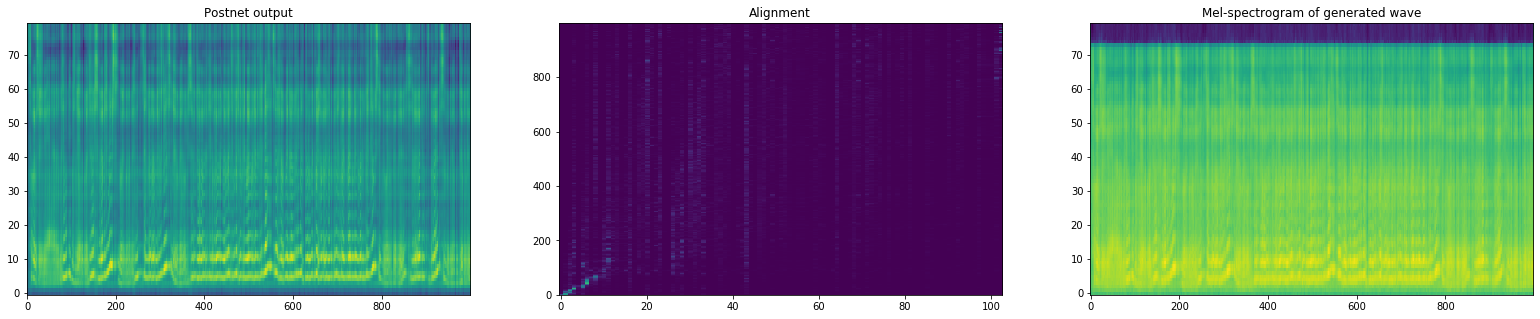

In [12]:
plt.figure(figsize=(27, 5));

plt.subplot(1, 3, 1);
plt.imshow(mel.cpu().squeeze().detach().numpy(), aspect='auto', origin='bottom');
plt.title('Postnet output');

plt.subplot(1, 3, 2);
plt.imshow(alignments.cpu().squeeze().detach().numpy().T, aspect='auto', origin='bottom');
plt.title('Alignment')
plt.xlabel('decoder step')
plt.ylabel('encoder step')
plt.colorbar();

plt.subplot(1, 3, 3);
plt.imshow(np.log(librosa.feature.melspectrogram(y=wave.cpu().numpy().squeeze(),
                                                 n_fft=1024, hop_length=256, win_length=1024, n_mels=80)),
           aspect='auto', origin='bottom');
plt.title('Mel-spectrogram of generated wave');